# Gearbox model


In [1]:
from joblib import load
from joblib import dump
gb_model = load("../01_Models/rf_18_35_0.9_6_2_gear.joblib")

In [2]:
def bearing_friction_torque(df):
    df["Temperature_Filtered"] = df["T_ST_LF1"].rolling(50, center=True).mean()
    df = df.dropna().copy()
    pred_gear_torque = gb_model.predict(df[["EP_Phiz", "EP_Vz", "EP_Az", "Temperature_Filtered"]].to_numpy())
    df["Bearing_Torque"] = df["EP_Tz_TorqueMeter"].to_numpy() - pred_gear_torque
    return df

# Data loading

In [3]:
from pandas import read_parquet, concat
def load_data(experiment_list):
    df_list = []
    for exp in experiment_list:
        df_list.append(
            bearing_friction_torque(
                read_parquet(f"../00_Input/{exp}_rev_9_10_11.parquet")
            )
        )
    return concat(df_list, ignore_index=True)

# Method comparison

- Training: done on 80% split of all datasets
- Testing: done on 20% split of all datasets
- Visualisation: done on dataset 01620163 and 01730173

In [4]:
TARGET = "Bearing_Torque"
FEATURES = ["EP_Az", "EP_Phiz", "EP_Vz", "LAS_Fx", "LAS_Fy", "LAS_Fz", "LAS_Mx", "LAS_My", "Bear friction upper", "Bear friction lower"]
EXPERIMENT_LIST = ["01620163", "01720173", "01740175", "01760177", "01780179", "02000201", "02130214", "02170218", "02210222", "02230224", "02350236", "02490250", "02510252", "02590260", "02670268", "02690270", "02830284", "02850286", "02870288", "02910292", "02950296", "03020303", "03040305"]
RANDOM_STATE = int(3)
TRAIN_SIZE = 0.8
V_MAX = 0.4

## Load and prepare data

In [5]:
df = load_data(EXPERIMENT_LIST)
df = df[df["EP_Vz"].abs() >= V_MAX] # remove speeds < V_MAX
df.describe()

,EP_Az,EP_Phiz,EP_Vz,LAS_Fx,LAS_Fy,LAS_Fz,LAS_Mx,LAS_My,Bear friction upper,Bear friction lower,T_ST_LF1,EP_Tz_TorqueMeter,Temperature_Filtered,Bearing_Torque
count,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08,1.037684e+08
mean,-9.249906e-03,-2.282349e+01,-6.006914e-03,-1.600794e-04,-9.540788e-05,1.394823e+01,-1.178925e-03,5.468595e+01,1.810882e+02,1.839578e+02,2.809197e+01,-2.703009e+01,2.809197e+01,-1.646383e+01
std,2.120041e+00,1.420771e+01,3.039755e+00,1.324066e-02,1.128918e-02,6.619184e+01,3.897731e+01,4.094423e+01,4.324897e+01,4.737443e+01,3.938853e+00,1.109424e+03,3.938847e+00,4.024647e+02
min,-6.738000e+01,-5.998000e+01,-1.053000e+01,-7.300000e-01,-6.600000e-01,-5.004300e+02,-9.106000e+01,-1.273600e+02,1.000000e+02,8.500000e+01,1.678390e+01,-7.016130e+03,1.679604e+01,-6.463759e+03
25%,-1.000000e-02,-3.458000e+01,-5.000000e-01,0.000000e+00,0.000000e+00,2.000000e-02,-1.916000e+01,2.316000e+01,1.560000e+02,1.640000e+02,2.520504e+01,-8.746900e+02,2.520525e+01,-3.520515e+02
50%,0.000000e+00,-2.264000e+01,-5.000000e-01,0.000000e+00,0.000000e+00,2.498000e+01,0.000000e+00,5.303000e+01,1.830000e+02,1.850000e+02,2.784362e+01,-5.276900e+02,2.784342e+01,-3.342083e+01
75%,1.000000e-02,-1.069000e+01,5.000000e-01,0.000000e+00,0.000000e+00,4.994000e+01,1.916000e+01,8.839000e+01,2.130000e+02,2.200000e+02,3.148568e+01,8.012400e+02,3.148579e+01,3.115774e+02
max,7.037000e+01,9.190000e+00,1.081000e+01,6.800000e-01,7.300000e-01,2.006500e+02,9.005000e+01,1.260700e+02,2.500000e+02,2.490000e+02,3.470594e+01,3.208340e+03,3.469875e+01,2.217214e+03


In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[FEATURES + [TARGET]], random_state=RANDOM_STATE, train_size=TRAIN_SIZE, shuffle=True)

In [7]:
train_df = train.sort_index().reset_index(drop=True)
test_df = test.sort_index().reset_index(drop=True)

In [8]:
X_train = train_df.loc[:, train_df.columns!=TARGET].to_numpy()
X_test = test_df.loc[:, test_df.columns!=TARGET].to_numpy()
y_train = train_df[TARGET].to_numpy()
y_test = test_df[TARGET].to_numpy()

## Neuronal network

In [9]:
from sklearn.neural_network import MLPRegressor
from modul_archiv_box import evaluate_model

mlp_model = MLPRegressor(hidden_layer_sizes=(64,64,), batch_size=1024, max_iter=200, verbose=True, random_state=RANDOM_STATE)
mlp_model.fit(X_train, y_train)
dump(mlp_model, f"../01_Models/mlp_model.joblib", compress=("gzip", 5))
y_pred_mlp = mlp_model.predict(X_test)
print(evaluate_model(y_test, y_pred_mlp, mlp_model, return_size=False))

Iteration 1, loss = 5624.23038751
Iteration 2, loss = 3082.96343013
Iteration 3, loss = 2724.51485423
Iteration 4, loss = 2498.58781234
Iteration 5, loss = 2377.25246274
Iteration 6, loss = 2305.79770224
Iteration 7, loss = 2249.09654449
Iteration 8, loss = 2205.89059417
Iteration 9, loss = 2173.44564450
Iteration 10, loss = 2145.87399171
Iteration 11, loss = 2119.19689909
Iteration 12, loss = 2094.54960711
Iteration 13, loss = 2071.16049014
Iteration 14, loss = 2052.50410151
Iteration 15, loss = 2035.72196991
Iteration 16, loss = 2022.67908641
Iteration 17, loss = 2010.46011884
Iteration 18, loss = 1999.02310569
Iteration 19, loss = 1989.31721094
Iteration 20, loss = 1980.28663000
Iteration 21, loss = 1971.60135561
Iteration 22, loss = 1963.48675333
Iteration 23, loss = 1956.38379490
Iteration 24, loss = 1949.66843047
Iteration 25, loss = 1943.13892173
Iteration 26, loss = 1936.57998548
Iteration 27, loss = 1930.67046440
Iteration 28, loss = 1924.97460571
Iteration 29, loss = 1920.000

C:\Users\menoli\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'RMSE': 58.786327, 'MAE': 43.543686, 'MAPE': 0.337253, 'R2_SCORE': 0.9786582, 'ADJ_R2_SCORE': 0.97865819}


## Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from modul_archiv_box import evaluate_model

lrg_model = LinearRegression()
lrg_model.fit(X_train, y_train)
dump(lrg_model, f"../01_Models/lrg_model.joblib", compress=("gzip", 5))
y_pred_lrg = lrg_model.predict(X_test)
print(evaluate_model(y_test, y_pred_lrg, lrg_model, return_size=False))

{'RMSE': 284.19295, 'MAE': 240.22342, 'MAPE': 1.181697, 'R2_SCORE': 0.50122452, 'ADJ_R2_SCORE': 0.5012243}


## Gradient Boosting

In [11]:
from sklearn.ensemble import HistGradientBoostingRegressor
from modul_archiv_box import evaluate_model

hist_model = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
hist_model.fit(X_train, y_train)
dump(hist_model, f"../01_Models/hist_model.joblib", compress=("gzip", 5))
y_pred_hist = hist_model.predict(X_test)
print(evaluate_model(y_test, y_pred_hist, hist_model, return_size=False))

{'RMSE': 71.317405, 'MAE': 53.546397, 'MAPE': 0.555238, 'R2_SCORE': 0.96858988, 'ADJ_R2_SCORE': 0.96858987}


## Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from modul_archiv_box import evaluate_model

RF_model = RandomForestRegressor(n_estimators=30, max_depth=30, max_features=0.8, min_samples_split=4, min_samples_leaf=1, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
RF_model.fit(X_train, y_train)
dump(RF_model, f"../01_Models/RF_model.joblib", compress=("gzip", 5))
y_pred_RF = RF_model.predict(X_test)
print(evaluate_model(y_test, y_pred_RF, RF_model, return_size=False))

{'RMSE': 29.21584, 'MAE': 20.536249, 'MAPE': 0.132399, 'R2_SCORE': 0.99472873, 'ADJ_R2_SCORE': 0.99472873}


## Decision tree

In [13]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt_model.fit(X_train, y_train)
dump(dt_model, f"../01_Models/dt_model.joblib", compress=("gzip", 5))
y_pred_dt = dt_model.predict(X_test)
print(evaluate_model(y_test, y_pred_dt, dt_model, return_size=False))

{'RMSE': 32.785841, 'MAE': 21.251639, 'MAPE': 0.130278, 'R2_SCORE': 0.99336179, 'ADJ_R2_SCORE': 0.99336178}


## Visualization

In [14]:
from pandas import Timedelta
VISUALIZE_FOR  = ["01620163", "01720173"]
VISUALIZE_FROM = Timedelta("0 days 05:34:45")
VISUALIZE_TO   = Timedelta("0 days 05:39:25")
VISUALIZE = ["Duration", "Measured", "Decision tree", "Random forest", "Linear regression", "Neuronal network", "Gradient boosting"]

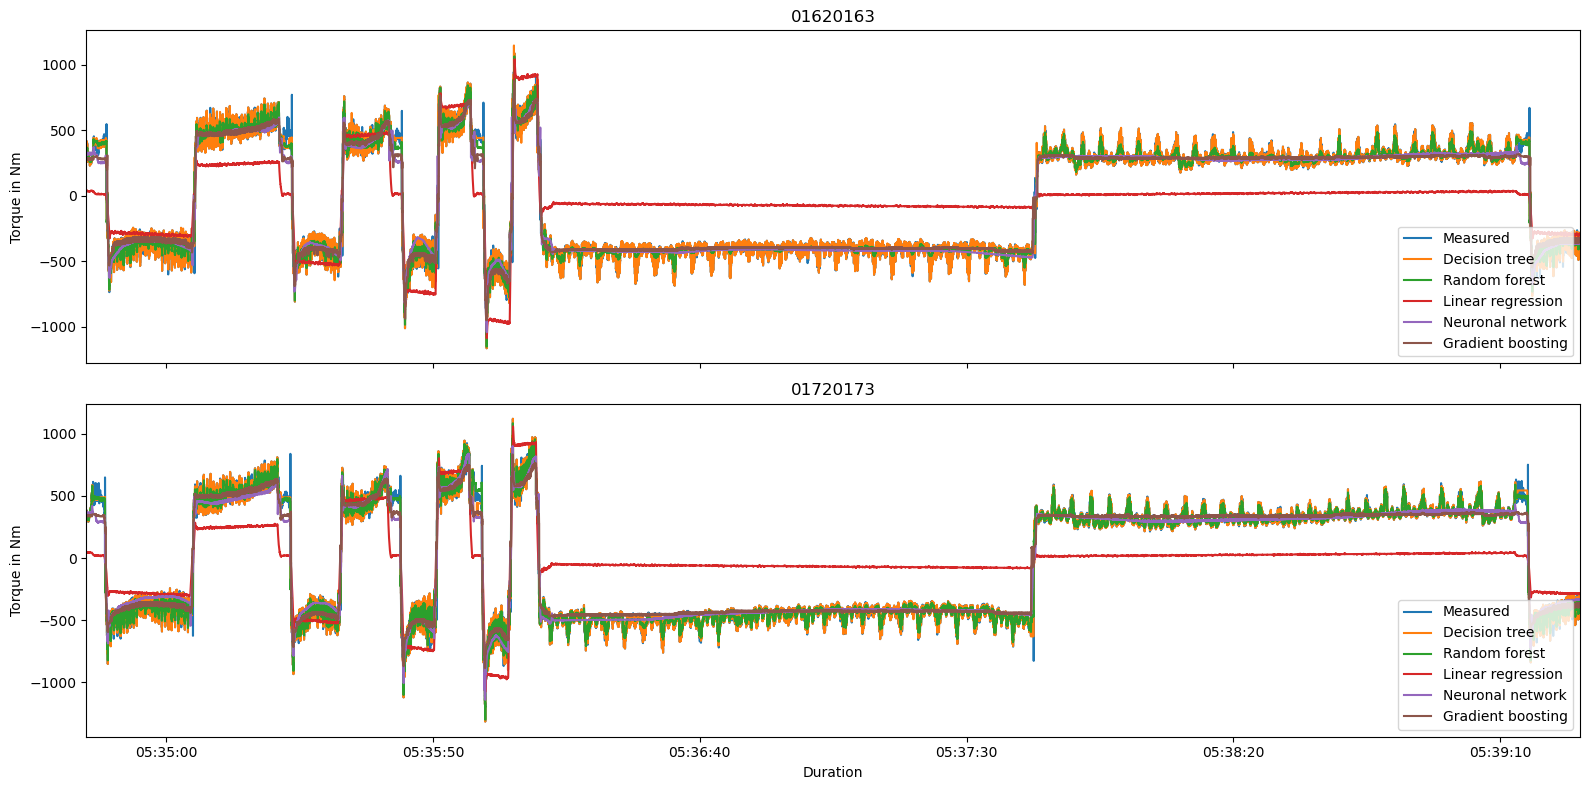

In [15]:
from pandas import timedelta_range
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(VISUALIZE_FOR), figsize=(20, 100), sharex=True)

for idx, exp in enumerate(VISUALIZE_FOR):
    df = load_data([exp])

    X_vis = df[FEATURES].to_numpy()

    pred = df[[TARGET]].copy()
    pred = pred.rename(columns={"Bearing_Torque": "Measured"})
    pred["Duration"] = timedelta_range(start = 0, periods = df[TARGET].shape[0], freq="5L")
    pred["Decision tree"] = dt_model.predict(X_vis)
    pred["Random forest"] = RF_model.predict(X_vis)
    pred["Linear regression"] = lrg_model.predict(X_vis)
    pred["Neuronal network"] = mlp_model.predict(X_vis)
    pred["Gradient boosting"] = hist_model.predict(X_vis)

    vis_df = pred[VISUALIZE][(pred["Duration"]>VISUALIZE_FROM) & (pred["Duration"]<VISUALIZE_TO)]
    vis_df.plot(x="Duration", figsize=(16, 8), ax=ax[idx])
    ax[idx].legend(loc="lower right")
    ax[idx].set_title(exp)
    ax[idx].set_ylabel("Torque in Nm")
    ax[idx].tick_params(axis="both")

    vis_df.to_parquet(f"../03_Results/method_comparison_{exp}.parquet", compression="snappy")

fig.tight_layout()
fig.savefig("../03_Results/method_comparison.png")
fig.savefig("../03_Results/method_comparison.pdf")
plt.show()

# Random forest vs empirical formula

- Training: done on 80% split of all datasets
- Testing: done on 20% split of all datasets
- Visualisation: done on dataset 01620163 and 01730173

## Visualization

In [16]:
from pandas import Timedelta
VISUALIZE_FOR  = ["01620163", "01720173"]
VISUALIZE_FROM = Timedelta("0 days 05:34:45")
VISUALIZE_TO   = Timedelta("0 days 05:39:25")

Empirical 01620163: {'RMSE': 180.041911, 'MAE': 118.558011, 'MAPE': 0.591816, 'R2_SCORE': 0.77102237, 'ADJ_R2_SCORE': 0}
Random forest 01620163: {'RMSE': 128.151266, 'MAE': 36.999188, 'MAPE': 0.1482, 'R2_SCORE': 0.88399102, 'ADJ_R2_SCORE': 0}
Empirical 01720173: {'RMSE': 169.665487, 'MAE': 111.506194, 'MAPE': 0.376531, 'R2_SCORE': 0.86132442, 'ADJ_R2_SCORE': 0}
Random forest 01720173: {'RMSE': 152.107484, 'MAE': 32.836434, 'MAPE': 0.133143, 'R2_SCORE': 0.88854126, 'ADJ_R2_SCORE': 0}


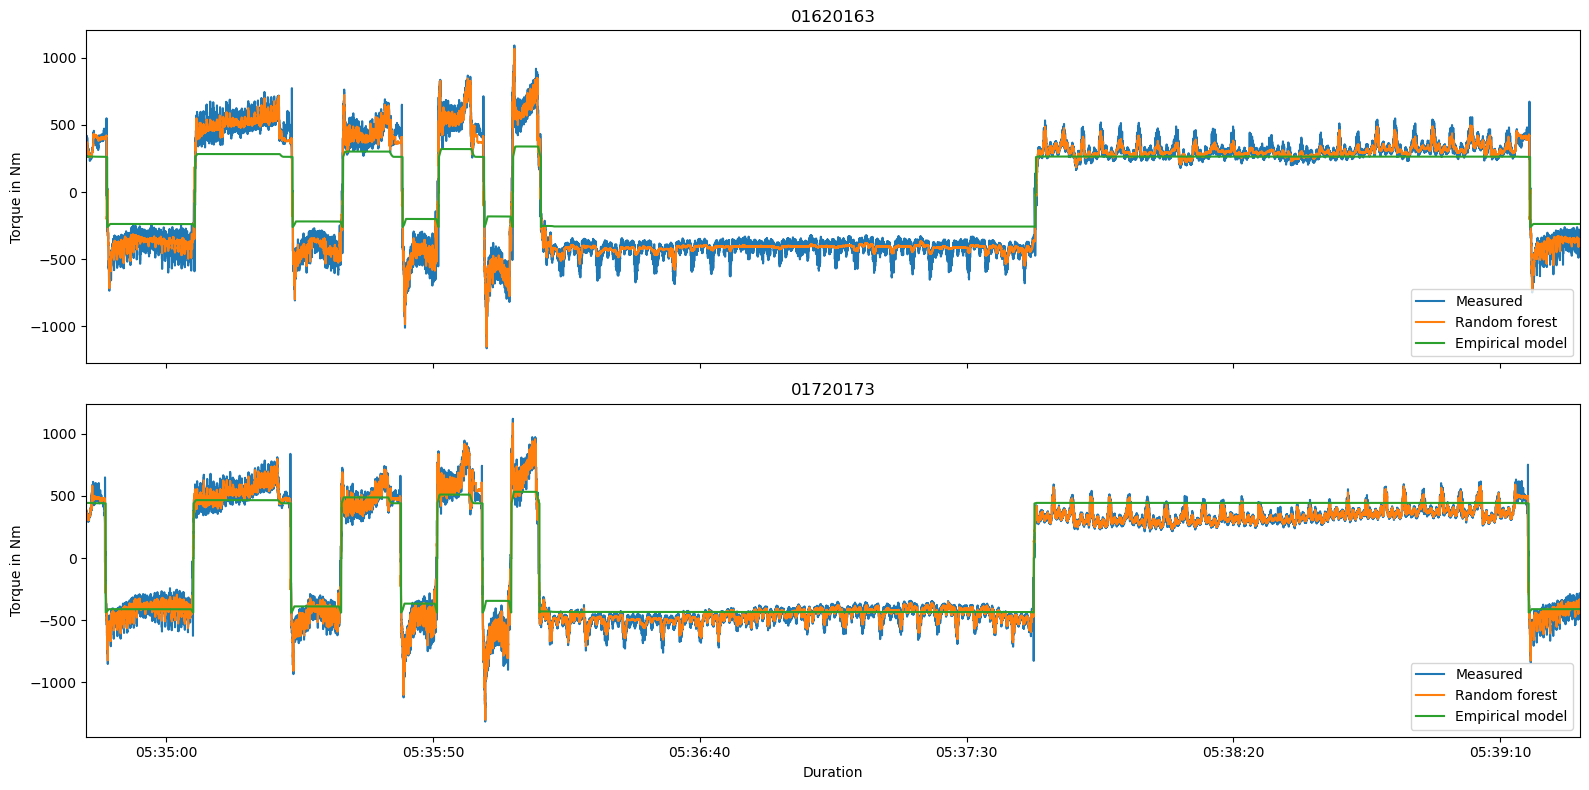

In [17]:
from pandas import timedelta_range, read_parquet
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(VISUALIZE_FOR), figsize=(20, 100), sharex=True)

for idx, exp in enumerate(VISUALIZE_FOR):
    df = load_data([exp])
    emp = read_parquet(f"../00_Input/Empirical_Prediction/{exp}.parquet")

    X_vis = df[FEATURES].to_numpy()

    pred = df[[TARGET]].copy()
    pred = pred.rename(columns={"Bearing_Torque": "Measured"})
    pred["Duration"] = timedelta_range(start = 0, periods = df[TARGET].shape[0], freq="5L")
    pred["Random forest"] = RF_model.predict(X_vis)
    pred["Empirical model"] = emp["FricTorqueFit"] * 2

    print(f"Empirical {exp}: {evaluate_model(pred['Measured'].to_numpy(), pred['Empirical model'].to_numpy())}")
    print(f"Random forest {exp}: {evaluate_model(pred['Measured'].to_numpy(), pred['Random forest'].to_numpy())}")

    vis_df = pred[:][(pred["Duration"]>VISUALIZE_FROM) & (pred["Duration"]<VISUALIZE_TO)]
    vis_df.plot(x="Duration", figsize=(16, 8), ax=ax[idx])
    ax[idx].legend(loc="lower right")
    ax[idx].set_title(exp)
    ax[idx].set_ylabel("Torque in Nm")
    ax[idx].tick_params(axis="both")

    vis_df.to_parquet(f"../03_Results/empirical_comparison_{exp}.parquet", compression="snappy")
    
fig.tight_layout()
fig.savefig("../03_Results/empirical_comparison.png")
fig.savefig("../03_Results/empirical_comparison.pdf")
plt.show()

# Prepare Datasets: unknown test setup

- Training: don on all datasets except 01620163 and 01730173
- Testing: done on dataset 01620163 and 01730173
- Visualisation: done on dataset 01620163 and 01730173

In [18]:
TARGET = "Bearing_Torque"
FEATURES = ["EP_Az", "EP_Phiz", "EP_Vz", "LAS_Fx", "LAS_Fy", "LAS_Fz", "LAS_Mx", "LAS_My", "Bear friction upper", "Bear friction lower"]
TRAIN_LIST = ["01740175", "01760177", "01780179", "02000201", "02130214", "02170218", "02210222", "02230224", "02350236", "02490250", "02510252", "02590260", "02670268", "02690270", "02830284", "02850286", "02870288", "02910292", "02950296", "03020303", "03040305"]
TEST_LIST = ["01620163", "01720173"]
RANDOM_STATE = 3

## Load and prepare data

In [19]:
from sklearn.model_selection import train_test_split
train = load_data(TRAIN_LIST)
train = train[FEATURES + [TARGET]]
train = train[train["EP_Vz"].abs() >= V_MAX] # remove speeds < V_MAX
train.describe()

,EP_Az,EP_Phiz,EP_Vz,LAS_Fx,LAS_Fy,LAS_Fz,LAS_Mx,LAS_My,Bear friction upper,Bear friction lower,Bearing_Torque
count,9.474516e+07,9.474516e+07,9.474516e+07,9.474516e+07,9.474516e+07,9.474516e+07,9.474516e+07,9.474516e+07,9.474516e+07,9.474516e+07,9.474516e+07
mean,-9.250155e-03,-2.282345e+01,-6.009656e-03,-1.573594e-04,-1.029470e-04,1.394801e+01,-1.364552e-03,5.468580e+01,1.793347e+02,1.818109e+02,-1.656135e+01
std,2.120107e+00,1.420774e+01,3.039750e+00,1.334493e-02,1.130498e-02,6.619200e+01,3.897756e+01,4.094418e+01,4.207582e+01,4.725522e+01,4.018083e+02
min,-6.738000e+01,-5.998000e+01,-1.053000e+01,-7.300000e-01,-6.600000e-01,-5.004300e+02,-9.106000e+01,-1.273600e+02,1.000000e+02,8.500000e+01,-6.463759e+03
25%,-1.000000e-02,-3.458000e+01,-5.000000e-01,0.000000e+00,0.000000e+00,2.000000e-02,-1.915000e+01,2.315000e+01,1.560000e+02,1.710000e+02,-3.466521e+02
50%,0.000000e+00,-2.264000e+01,-5.000000e-01,0.000000e+00,0.000000e+00,2.498000e+01,0.000000e+00,5.303000e+01,1.830000e+02,1.850000e+02,-3.035993e+01
75%,1.000000e-02,-1.069000e+01,5.000000e-01,0.000000e+00,0.000000e+00,4.995000e+01,1.916000e+01,8.839000e+01,2.130000e+02,2.070000e+02,3.054023e+02
max,7.037000e+01,9.190000e+00,1.079000e+01,6.800000e-01,7.300000e-01,2.006500e+02,9.005000e+01,1.260700e+02,2.490000e+02,2.490000e+02,2.217214e+03


In [20]:
test = load_data(TEST_LIST)
test = test[FEATURES + [TARGET]]
test = test[test["EP_Vz"].abs() >= V_MAX] # remove speeds < V_MAX
test.describe()

,EP_Az,EP_Phiz,EP_Vz,LAS_Fx,LAS_Fy,LAS_Fz,LAS_Mx,LAS_My,Bear friction upper,Bear friction lower,Bearing_Torque
count,9.023207e+06,9.023207e+06,9.023207e+06,9.023207e+06,9.023207e+06,9.023207e+06,9.023207e+06,9.023207e+06,9.023207e+06,9.023207e+06,9.023207e+06
mean,-9.247291e-03,-2.282388e+01,-5.978120e-03,-1.886402e-04,-1.624589e-05,1.395054e+01,7.701874e-04,5.468756e+01,1.994999e+02,2.064999e+02,-1.543984e+01
std,2.119351e+00,1.420741e+01,3.039807e+00,1.209157e-02,1.112158e-02,6.619017e+01,3.897470e+01,4.094475e+01,5.050000e+01,4.250000e+01,4.092920e+02
min,-3.300000e+01,-5.998000e+01,-1.049000e+01,-4.700000e-01,-3.500000e-01,-5.002600e+02,-8.902000e+01,-1.258200e+02,1.490000e+02,1.640000e+02,-1.765688e+03
25%,-1.000000e-02,-3.458000e+01,-5.000000e-01,0.000000e+00,0.000000e+00,2.000000e-02,-1.917000e+01,2.317000e+01,1.490000e+02,1.640000e+02,-3.969059e+02
50%,0.000000e+00,-2.264000e+01,-5.000000e-01,0.000000e+00,0.000000e+00,2.498000e+01,0.000000e+00,5.303000e+01,1.490000e+02,1.640000e+02,-1.551381e+02
75%,1.000000e-02,-1.069000e+01,5.000000e-01,0.000000e+00,0.000000e+00,4.994000e+01,1.916000e+01,8.839000e+01,2.500000e+02,2.490000e+02,3.545017e+02
max,2.499000e+01,2.380000e+00,1.081000e+01,5.400000e-01,7.100000e-01,2.002900e+02,8.936000e+01,1.260400e+02,2.500000e+02,2.490000e+02,1.776643e+03


In [21]:
train_df = train.sort_index().reset_index(drop=True)
test_df = test.sort_index().reset_index(drop=True)

In [22]:
X_train = train_df.loc[:, train_df.columns!=TARGET].to_numpy()
X_test = test_df.loc[:, test_df.columns!=TARGET].to_numpy()
y_train = train_df[TARGET].to_numpy()
y_test = test_df[TARGET].to_numpy()

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
from modul_archiv_box import evaluate_model

RF_model = RandomForestRegressor(n_estimators=30, max_depth=30, max_features=0.8, min_samples_split=4, min_samples_leaf=1, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
RF_model.fit(X_train, y_train)

y_pred_RF = RF_model.predict(X_test)
print(f"Testdata: {evaluate_model(y_test, y_pred_RF, RF_model, return_size=False)}")

Testdata: {'RMSE': 103.985332, 'MAE': 78.035292, 'MAPE': 0.215391, 'R2_SCORE': 0.93545276, 'ADJ_R2_SCORE': 0.93545269}


## Decision tree

In [24]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(evaluate_model(y_test, y_pred_dt, dt_model, return_size=False))

{'RMSE': 112.517601, 'MAE': 85.469984, 'MAPE': 0.240868, 'R2_SCORE': 0.92442565, 'ADJ_R2_SCORE': 0.92442557}


## Visualization

In [25]:
from pandas import Timedelta
VISUALIZE_FOR  = ["01620163", "01720173"]
VISUALIZE_FROM = Timedelta("0 days 05:34:45")
VISUALIZE_TO   = Timedelta("0 days 05:39:25")

Random forest 01620163: {'RMSE': 143.743314, 'MAE': 68.475128, 'MAPE': 0.252718, 'R2_SCORE': 0.85404428, 'ADJ_R2_SCORE': 0}
Random forest 01720173: {'RMSE': 172.928581, 'MAE': 111.041096, 'MAPE': 0.278201, 'R2_SCORE': 0.85593897, 'ADJ_R2_SCORE': 0}


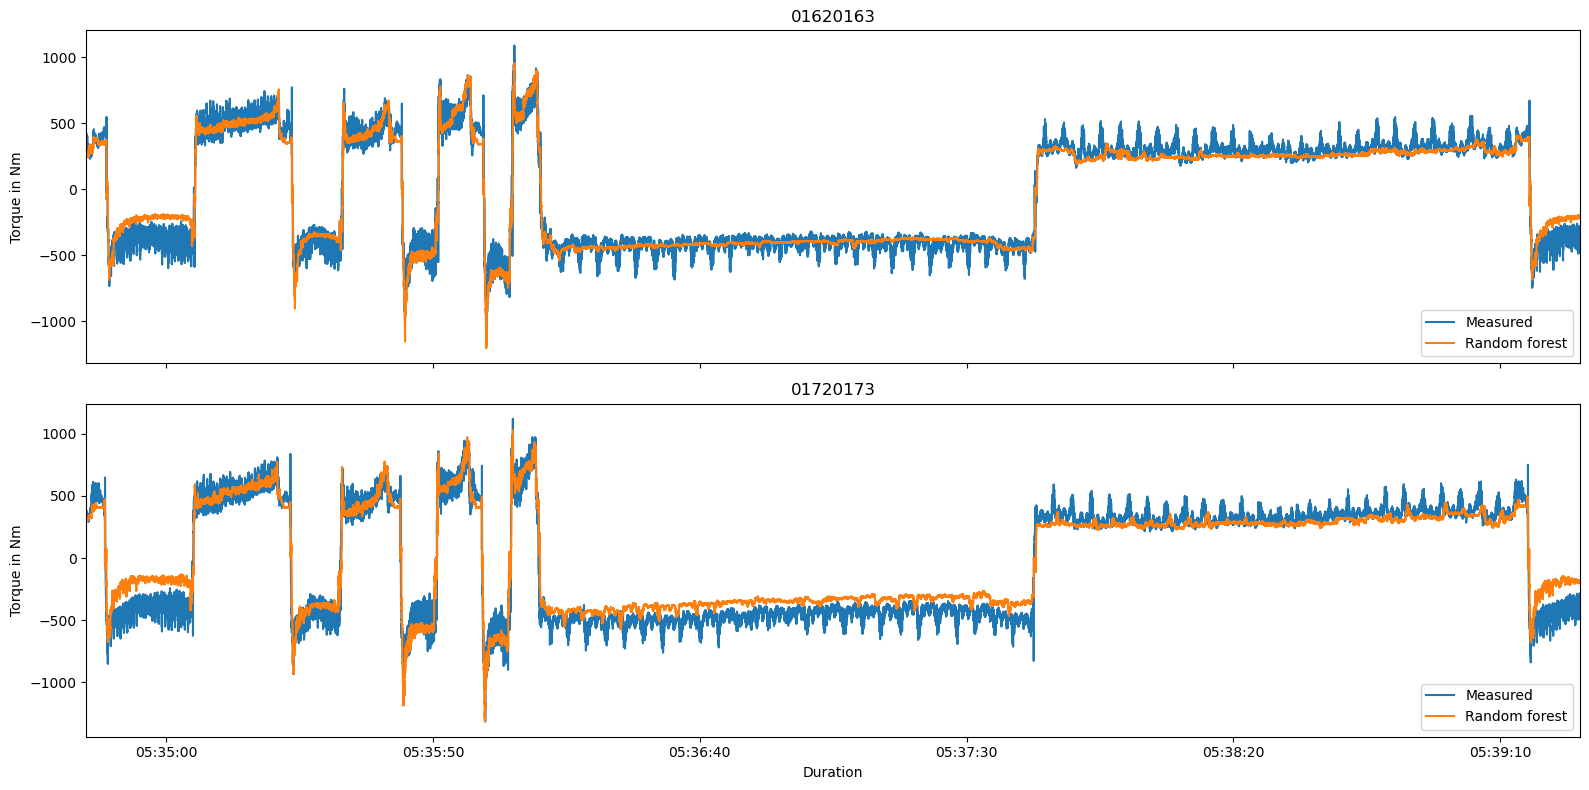

In [26]:
from pandas import timedelta_range
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(VISUALIZE_FOR), figsize=(20, 100), sharex=True)

for idx, exp in enumerate(VISUALIZE_FOR):
    df = load_data([exp])

    X_vis = df[FEATURES].to_numpy()

    pred = df[[TARGET]].copy()
    pred = pred.rename(columns={"Bearing_Torque": "Measured"})
    pred["Duration"] = timedelta_range(start = 0, periods = df[TARGET].shape[0], freq="5L")
    pred["Random forest"] = RF_model.predict(X_vis)

    print(f"Random forest {exp}: {evaluate_model(pred['Measured'].to_numpy(), pred['Random forest'].to_numpy())}")

    vis_df = pred[:][(pred["Duration"]>VISUALIZE_FROM) & (pred["Duration"]<VISUALIZE_TO)]
    vis_df.plot(x="Duration", figsize=(16, 8), ax=ax[idx])
    ax[idx].legend(loc="lower right")
    ax[idx].set_title(exp)
    ax[idx].set_ylabel("Torque in Nm")
    ax[idx].tick_params(axis="both")

    vis_df.to_parquet(f"../03_Results/method_unknown_test_setup_{exp}.parquet", compression="snappy")

fig.tight_layout()
fig.savefig("../03_Results/method_unknown_test_setup.png")
fig.savefig("../03_Results/method_unknown_test_setup.pdf")
plt.show()